# Proyecto Final: Modelo Predictivo de Burnout
## Combinación y Optimización de Notebooks

### 1. Importación de Dependencias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, r2_score, mean_absolute_error
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import pickle
import warnings

warnings.filterwarnings('ignore')

# Configuraciones para evitar límites en la visualización de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

### 2. Carga del Dataset

In [2]:
try:
    dataset = pd.read_csv('Proyecto_final.csv', sep=';')
    print("Dataset cargado correctamente.")
    display(dataset.head())
except FileNotFoundError:
    print("Error: El archivo 'Proyecto_final.csv' no se encontró. Asegúrate de que esté en el directorio correcto.")

Dataset cargado correctamente.


,Id,Incorporacion,Formulario,Horadeinicio,Horadefinalización,HoraRealizacion,TiempoRequerido,CI,Sexo,Edad,EstadoCivil,Convivientes,Hijos,Form_Asist_Sup,Carrera_Esp_Universitaria,Posgrado_Carrera_Universitaria,Diplomatura,Maestria,Doctorado,Jerarquia,Especialidad,AñosPractica,HorasTrabajoSemanal,N_instituciones_trabaja,TiempoEnViaje,Guardia,UTI_UCIM_UCO,Quirófano,Sala_Internacion,ConsExt,Labo_Imágenes,Habitos_Alimentación_Frutas,Habitos_Alimentacion_Verduras,Habitos_Actividad_Fisica,Habitos_Relajacion,Habitos_Actividad_Social,Habitos_Alcohol,Habitos_Tabaquismo,Habitos_Sueño,Puntaje_Habitos,MBI_1,MBI_2,MBI_3,MBI_4,MBI_5,MBI_6,MBI_7,MBI_8,MBI_9,MBI_10,MBI_11,MBI_12,MBI_13,MBI_14,MBI_15,MBI_16,MBI_17,MBI_18,MBI_19,MBI_20,MBI_21,MBI_22,AE_MBI,DSP_MBI,RP_MBI,Nivel_AE_MBI,Nivel_DSP_MBI,Nivel_RP_MBI,MBI_Burnout,MBI_RiesgoBurnout1,PERMA_1_Progreso_Metas,PERMA_2_Concentra,PERMA_3_Feliz,PERMA_4_Estres,PERMA_5_Alcance_Metas,PERMA_6_Salud,PERMA_7_Vida_Significativa,PERMA_8_Ayuda_Compañia,PERMA_9_Valor_Vida,PERMA_10_Entusiasmo,PERMA_11_Soledad,PERMA_12_Satisfaccion_Salud,PERMA_13_Optimismo,PERMA_14_Enojo,PERMA_15_Asumir_Responsabilidad,PERMA_16_Triste,PERMA_17_Perder_nocion_tiempo_por_gusto,PERMA_18_Salud_comparada,PERMA_19_Sentirse_amado,PERMA_20_Sentido_de_vida,PERMA_21_Satisfaccion_relaciones_personales,PERMA_22_Contento,PERMA_23_Feliz,PERMA_Puntaje,LGS_1,LGS_2,LGS_3,LGS_4,LGS_5,LGS_6,LGS_7,LGS_8,LGS_9,LGS_10,LGS_11,LGS_12,LGS_13,LGS_14,LGS_15,LGS_16,LGS_17,LGS_18,LGS_19,LGS_20,LGS_Puntaje,GBC_1,GBC_2,GBC_3,GBC_4,GBC_5,GBC_6,GBC_7,GBC_8,GBC_9,GBC_10,GBC_11,GBC_12,GBC_13,GBC_14,GBC_15,GBC_16,GBC_17,GBC_18,GBC_19,GBC_20,GBC_21,GBC_22,GBC_23,GBC_24,GBC_25,GBC_26,GBC_27,GBC_28,GBC_29,GBC_Puntaje
0,1,0,1,5/1/2025 22:00,5/1/2025 22:13,"22,00","13,32",1,1,999,1,999,1,0,0,999,999,999,999,2,999,999,999.0,999,999,1,0,0,0,0,0,1,4,4,4,4,4,0,-2,11,2,2,2,2,2,2,2,1,4,3,3,6,1,5,1,3,4,3,3,2,0,2,20,11,24,1,2,0,0,1,7,6,6,8,7,8,8,3,8,7,3,8,7,7,5,3,8,8,8,8,7,7,9,NaN,2,1,2,2,0,1,2,1,0,1,1,2,0,0,0,2,2,1,2,2,NaN,0,2,2,1,0,1,2,2,1,2,1,1,1,1,1,2,1,0,1,2,1,1,1,2,2,1,1,1,0,NaN
1,2,1,1,9/1/2025 17:10,9/1/2025 17:34,"17,00","23,80",1,0,56,2,3,1,4,1,0,0,0,0,3,13,34,51.0,4,90,0,0,0,1,0,0,3,3,0,2,2,3,0,-1,6,4,1,5,6,0,5,5,5,5,0,0,4,4,6,0,3,5,6,5,4,4,3,37,3,40,2,0,2,0,1,5,7,4,8,5,6,6,7,7,6,5,4,5,4,8,7,8,5,6,6,6,5,6,NaN,2,1,2,1,1,1,1,1,0,0,3,2,3,1,1,3,1,3,1,0,NaN,0,0,2,2,0,0,2,2,2,1,2,2,0,1,2,2,1,0,2,2,2,1,1,2,1,1,0,1,0,NaN
2,3,1,1,9/1/2025 18:05,9/1/2025 18:34,"18,00","29,57",1,0,51,0,4,1,3,0,0,0,0,0,3,7,15,30.0,1,60,0,0,0,1,0,0,0,2,0,0,0,1,0,-2,-1,1,0,1,6,0,5,5,1,1,6,3,3,1,1,0,1,3,0,0,1,0,3,12,12,18,0,2,0,0,1,4,5,3,8,4,3,6,6,6,6,5,4,5,5,9,4,9,4,7,7,7,7,6,NaN,2,2,0,1,1,1,2,0,3,0,3,2,3,1,1,2,1,1,2,1,NaN,0,2,2,1,0,1,2,2,2,2,2,2,1,2,2,1,0,2,2,2,2,2,2,1,2,2,1,0,1,NaN
3,4,1,1,9/1/2025 18:03,9/1/2025 18:45,"18,00","41,90",1,0,40,0,1,0,4,1,0,0,0,0,3,13,11,10.0,3,140,0,0,0,1,1,0,2,4,2,0,1,2,0,-1,6,3,1,3,5,3,5,5,4,3,3,2,3,3,6,0,5,5,5,3,4,3,2,34,10,32,2,2,0,1,1,7,6,7,7,7,8,9,8,7,7,2,6,7,3,9,2,6,9,8,8,8,7,7,NaN,1,1,0,1,3,1,1,1,0,0,1,1,0,1,1,1,1,2,1,0,NaN,0,0,1,0,0,0,2,2,2,1,2,1,1,1,2,2,1,1,1,2,2,1,0,0,0,2,1,0,2,NaN
4,5,1,1,9/1/2025 18:35,9/1/2025 18:58,"18,00","22,20",1,0,42,0,0,0,3,0,0,0,0,0,3,7,18,30.0,1,30,0,0,0,1,0,0,2,2,0,0,0,1,0,1,4,4,0,4,6,1,4,5,5,4,5,3,5,4,3,0,4,6,6,3,3,3,3,31,12,38,2,2,1,0,1,7,8,7,4,7,7,7,3,7,7,1,7,7,3,8,3,8,8,8,8,8,7,7,NaN,2,1,1,2,2,1,2,1,2,1,1,1,2,1,1,1,2,2,2,1,NaN,1,1,1,2,0,1,2,2,2,1,2,2,2,2,2,2,1,0,2,2,2,1,2,0,1,2,2,1,1,NaN


### 3. Preprocesamiento de los Datos

In [3]:
print(f"El dataset tiene {dataset.shape[0]} filas y {dataset.shape[1]} columnas")
print("\n------------ Información General --------------------")
dataset.info()
print("\n------------- Estadísticas Descriptivas -------------------")
display(dataset.describe())
print("\n-------------- Valores Nulos (N/A) ------------------")
display(dataset.isnull().sum())
print("\n------------- Filas Duplicadas -------------------")
print(f"Se encontraron {dataset.duplicated().sum()} filas duplicadas.")

El dataset tiene 103 filas y 145 columnas

------------ Información General --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Columns: 145 entries, Id to GBC_Puntaje
dtypes: float64(4), int64(136), object(5)
memory usage: 116.8+ KB

------------- Estadísticas Descriptivas -------------------


,Id,Incorporacion,Formulario,CI,Sexo,Edad,EstadoCivil,Convivientes,Hijos,Form_Asist_Sup,Carrera_Esp_Universitaria,Posgrado_Carrera_Universitaria,Diplomatura,Maestria,Doctorado,Especialidad,AñosPractica,HorasTrabajoSemanal,N_instituciones_trabaja,TiempoEnViaje,Guardia,UTI_UCIM_UCO,Quirófano,Sala_Internacion,ConsExt,Labo_Imágenes,Habitos_Alimentación_Frutas,Habitos_Alimentacion_Verduras,Habitos_Actividad_Fisica,Habitos_Relajacion,Habitos_Actividad_Social,Habitos_Alcohol,Habitos_Tabaquismo,Habitos_Sueño,Puntaje_Habitos,MBI_1,MBI_2,MBI_3,MBI_4,MBI_5,MBI_6,MBI_7,MBI_8,MBI_9,MBI_10,MBI_11,MBI_12,MBI_13,MBI_14,MBI_15,MBI_16,MBI_17,MBI_18,MBI_19,MBI_20,MBI_21,MBI_22,AE_MBI,DSP_MBI,RP_MBI,Nivel_AE_MBI,Nivel_DSP_MBI,Nivel_RP_MBI,MBI_Burnout,MBI_RiesgoBurnout1,PERMA_1_Progreso_Metas,PERMA_2_Concentra,PERMA_3_Feliz,PERMA_4_Estres,PERMA_5_Alcance_Metas,PERMA_6_Salud,PERMA_7_Vida_Significativa,PERMA_8_Ayuda_Compañia,PERMA_9_Valor_Vida,PERMA_10_Entusiasmo,PERMA_11_Soledad,PERMA_12_Satisfaccion_Salud,PERMA_13_Optimismo,PERMA_14_Enojo,PERMA_15_Asumir_Responsabilidad,PERMA_16_Triste,PERMA_17_Perder_nocion_tiempo_por_gusto,PERMA_18_Salud_comparada,PERMA_19_Sentirse_amado,PERMA_20_Sentido_de_vida,PERMA_21_Satisfaccion_relaciones_personales,PERMA_22_Contento,PERMA_23_Feliz,PERMA_Puntaje,LGS_1,LGS_2,LGS_3,LGS_4,LGS_5,LGS_6,LGS_7,LGS_8,LGS_9,LGS_10,LGS_11,LGS_12,LGS_13,LGS_14,LGS_15,LGS_16,LGS_17,LGS_18,LGS_19,LGS_20,LGS_Puntaje,GBC_1,GBC_2,GBC_3,GBC_4,GBC_5,GBC_6,GBC_7,GBC_8,GBC_9,GBC_10,GBC_11,GBC_12,GBC_13,GBC_14,GBC_15,GBC_16,GBC_17,GBC_18,GBC_19,GBC_20,GBC_21,GBC_22,GBC_23,GBC_24,GBC_25,GBC_26,GBC_27,GBC_28,GBC_29,GBC_Puntaje
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,102.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.00000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,0.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.00000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.0
mean,52.000000,0.990291,1.436893,0.990291,10.233010,63.407767,10.398058,20.825243,10.330097,13.504854,9.980583,19.601942,19.524272,19.475728,19.398058,31.611650,37.184466,53.235294,22.320388,78.194175,10.029126,9.825243,10.009709,10.281553,10.417476,9.737864,12.067961,12.825243,12.135922,10.864078,11.213592,11.436893,10.067961,9.650485,18.155340,13.126214,11.456311,12.854369,14.902913,11.592233,13.223301,14.737864,13.446602,14.514563,12.854369,12.097087,13.747573,12.242718,13.475728,10.699029,12.776699,14.796117,14.330097,13.68932,12.067961,12.242718,11.631068,37.077670,20.077670,45.067961,10.980583,10.932039,10.796117,9.893204,10.436893,16.388350,16.495146,16.543689,16.320388,16.699029,16.669903,17.582524,16.902913,17.407767,16.951456,13.038835,15.611650,16.640777,14.689320,17.951456,13.737864,16.728155,16.737864,17.757282,17.61


-------------- Valores Nulos (N/A) ------------------


Id                                               0
Incorporacion                                    0
Formulario                                       0
Horadeinicio                                     0
Horadefinalización                               0
HoraRealizacion                                  0
TiempoRequerido                                  0
CI                                               0
Sexo                                             0
Edad                                             0
EstadoCivil                                      0
Convivientes                                     0
Hijos                                            0
Form_Asist_Sup                                   0
Carrera_Esp_Universitaria                        0
Posgrado_Carrera_Universitaria                   0
Diplomatura                                      0
Maestria                                         0
Doctorado                                        0
Jerarquia                      


------------- Filas Duplicadas -------------------
Se encontraron 0 filas duplicadas.


In [4]:
# Eliminación de columnas innecesarias
columns_to_drop = ['GBC_Puntaje', 'LGS_Puntaje', 'PERMA_Puntaje', 'Id', 'Formulario', 
                   'Horadeinicio', 'Horadefinalización', 'HoraRealizacion', 'TiempoRequerido', 'CI',
                   'Diplomatura', 'Maestria', 'Doctorado', 'AE_MBI', 'Nivel_AE_MBI', 'RP_MBI', 'Nivel_RP_MBI','DSP_MBI', 'Nivel_DSP_MBI']

dataset_cleaned = dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns])
print(f"Columnas eliminadas. Nuevo shape del dataset: {dataset_cleaned.shape}")

Columnas eliminadas. Nuevo shape del dataset: (103, 126)


In [5]:
# Tratamiento de valores especiales (999 = missing) y nulos
dataset_cleaned = dataset_cleaned.replace(999, np.nan)

# Eliminar filas con más del 50% de valores nulos
null_counts = dataset_cleaned.isnull().sum(axis=1)
rows_to_drop = null_counts[null_counts > dataset_cleaned.shape[1] * 0.5].index
print(f"Eliminando {len(rows_to_drop)} filas con >50% de nulos")
dataset_cleaned = dataset_cleaned.drop(rows_to_drop)

# Imputación de nulos en columnas numéricas con la mediana (robusto a outliers)
numeric_cols = dataset_cleaned.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if dataset_cleaned[col].isnull().sum() > 0:
        median_val = dataset_cleaned[col].median()
        dataset_cleaned[col].fillna(median_val, inplace=True)

print(f"Nulos restantes después de la imputación: {dataset_cleaned.isnull().sum().sum()}")

Eliminando 1 filas con >50% de nulos
Nulos restantes después de la imputación: 0


In [6]:
# Convertir variables numéricas discretas a categóricas
categorical_threshold = 20
for col in dataset_cleaned.select_dtypes(include=['number']).columns:
    if dataset_cleaned[col].nunique() < categorical_threshold:
        dataset_cleaned[col] = dataset_cleaned[col].astype('category')

# Asegurar que la columna 'Jerarquia' sea numérica y luego categórica
if 'Jerarquia' in dataset_cleaned.columns and dataset_cleaned['Jerarquia'].dtype == 'object':
    dataset_cleaned['Jerarquia'] = pd.to_numeric(dataset_cleaned['Jerarquia'], errors='coerce')
    # Imputar si se generaron NaNs
    if dataset_cleaned['Jerarquia'].isnull().sum() > 0:
        dataset_cleaned['Jerarquia'].fillna(dataset_cleaned['Jerarquia'].median(), inplace=True)
    dataset_cleaned['Jerarquia'] = dataset_cleaned['Jerarquia'].astype('category')

print("Tipos de datos después de la conversión:")
print(dataset_cleaned.dtypes.value_counts())

Tipos de datos después de la conversión:
category    32
category    19
category    18
category    10
category     8
category     6
float64      6
category     5
category     4
category     2
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64


In [7]:
# Análisis de distribución y asimetría (skewness)
numeric_cols = dataset_cleaned.select_dtypes(include=[np.number]).columns
skewness_df = dataset_cleaned[numeric_cols].skew().sort_values(ascending=False).reset_index()
skewness_df.columns = ['Column', 'Skewness']

print("Columnas con mayor asimetría (skewness > 1 o < -1):")
display(skewness_df[abs(skewness_df['Skewness']) > 1])

# Aplicar transformación logarítmica a columnas con alta asimetría positiva
skewed_cols = skewness_df[skewness_df['Skewness'] > 1]['Column'].tolist()
# Excluir las variables target
skewed_cols = [col for col in skewed_cols if col not in ['MBI_Burnout', 'MBI_RiesgoBurnout1']]

print(f"\nAplicando transformación logarítmica a {len(skewed_cols)} columnas")
for col in skewed_cols:
    dataset_cleaned[f'{col}_log'] = np.log1p(dataset_cleaned[col])
    dataset_cleaned = dataset_cleaned.drop(col, axis=1)
    print(f"✓ {col} transformada")

Columnas con mayor asimetría (skewness > 1 o < -1):


,Column,Skewness
0,TiempoEnViaje,1.160888



Aplicando transformación logarítmica a 1 columnas
✓ TiempoEnViaje transformada


### 4. Preparación para Entrenamiento

In [8]:
# Separar features (X) y targets (y)
target_cols = ['MBI_Burnout', 'MBI_RiesgoBurnout1']

# Tarea de Clasificación
y_classification = dataset_cleaned['MBI_Burnout'].copy()
X = dataset_cleaned.drop(columns=target_cols)

# Tarea de Regresión
y_regression = dataset_cleaned['MBI_RiesgoBurnout1'].copy()

# Codificar variables categóricas usando One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Shape de X (features) antes de codificar: {X.shape}")
print(f"Shape de X (features) después de codificar: {X_encoded.shape}")
print("\nDistribución de clases para clasificación:")
print(Counter(y_classification))

Shape de X (features) antes de codificar: (102, 124)
Shape de X (features) después de codificar: (102, 529)

Distribución de clases para clasificación:
Counter({0.0: 82, 1.0: 20})


In [9]:
# Separar conjunto de test (20%) que NO se usará hasta la evaluación final
# Para Clasificación
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Para Regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_encoded, y_regression, test_size=0.2, random_state=42
)

print(f"Set de entrenamiento (clasificación): {X_train_full.shape}")
print(f"Set de test (clasificación): {X_test.shape}")
print(f"\nDistribución en train: {Counter(y_train_full)}")
print(f"Distribución en test: {Counter(y_test)}")

Set de entrenamiento (clasificación): (81, 529)
Set de test (clasificación): (21, 529)

Distribución en train: Counter({0.0: 65, 1.0: 16})
Distribución en test: Counter({0.0: 17, 1.0: 4})


In [21]:
y_train_reg

54     0.0
22     1.0
69     1.0
45     0.0
99     1.0
15     1.0
74     1.0
40     0.0
9      1.0
85     0.0
11     1.0
102    1.0
56     1.0
28     1.0
65     1.0
5      1.0
79     0.0
66     1.0
36     1.0
16     1.0
92     0.0
35     1.0
7      1.0
44     1.0
73     1.0
27     1.0
19     1.0
84     1.0
25     0.0
78     0.0
50     1.0
13     1.0
24     1.0
3      1.0
17     1.0
39     0.0
8      0.0
81     1.0
6      1.0
67     0.0
37     1.0
90     0.0
57     0.0
96     0.0
55     1.0
51     1.0
70     1.0
47     1.0
71     0.0
62     1.0
100    1.0
82     1.0
42     1.0
59     1.0
49     0.0
89     1.0
58     1.0
76     1.0
33     1.0
97     0.0
60     1.0
64     0.0
95     0.0
38     1.0
29     1.0
1      1.0
53     1.0
21     1.0
2      1.0
23     1.0
88     1.0
94     1.0
75     1.0
87     1.0
83     1.0
20     1.0
61     0.0
72     0.0
14     1.0
93     1.0
52     1.0
Name: MBI_RiesgoBurnout1, dtype: category
Categories (2, float64): [0.0, 1.0]

### 5. Búsqueda de Hiperparámetros y Entrenamiento (Clasificación)

In [10]:
# Aplicar SMOTE y Escalado al conjunto completo de entrenamiento
print("Aplicando SMOTE al conjunto de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
print(f"Distribución después de SMOTE: {Counter(y_train_resampled)}")

# Identificar columnas a escalar
cols_to_scale = [col for col in X_train_resampled.columns if X_train_resampled[col].max() > 10]
print(f"\nSe escalarán {len(cols_to_scale)} columnas.")

# Escalar
scaler = StandardScaler()
X_train_scaled = X_train_resampled.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_resampled[cols_to_scale])

print("Datos de entrenamiento listos (SMOTE + Scaler).")

Aplicando SMOTE al conjunto de entrenamiento...
Distribución después de SMOTE: Counter({0.0: 65, 1.0: 65})

Se escalarán 5 columnas.
Datos de entrenamiento listos (SMOTE + Scaler).


In [11]:
# Definir el espacio de hiperparámetros para Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.2]
}


print("Iniciando GridSearchCV para el modelo de clasificación...")
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

grid_search_clf = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc_ovr', # 'ovr' para multiclase
    cv=5, # Usamos 5 folds para la validación cruzada
    verbose=1,
    n_jobs=-1
)

grid_search_clf.fit(X_train_scaled, y_train_resampled)

print("\n================ MEJORES HIPERPARÁMETROS (Clasificación) ================")
print(grid_search_clf.best_params_)
print(f"\nMejor AUC-ROC en CV: {grid_search_clf.best_score_:.4f}")

# Modelo final de clasificación
best_clf_model = grid_search_clf.best_estimator_

Iniciando GridSearchCV para el modelo de clasificación...
Fitting 5 folds for each of 14580 candidates, totalling 72900 fits

================ MEJORES HIPERPARÁMETROS (Clasificación) ================
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}

Mejor AUC-ROC en CV: 0.9751


### 6. Evaluación del Modelo de Clasificación en el Test Set


================ RESULTADOS FINALES EN TEST SET (Clasificación) ================

✓ Accuracy: 0.8095
✓ Precision (macro): 0.5000
✓ Recall (macro): 0.5000
✓ F1-Score (macro): 0.5000
✓ AUC-ROC: 0.7206

CLASSIFICATION REPORT
              precision    recall  f1-score   support

  No Burnout       0.88      0.88      0.88        17
     Burnout       0.50      0.50      0.50         4

    accuracy                           0.81        21
   macro avg       0.69      0.69      0.69        21
weighted avg       0.81      0.81      0.81        21



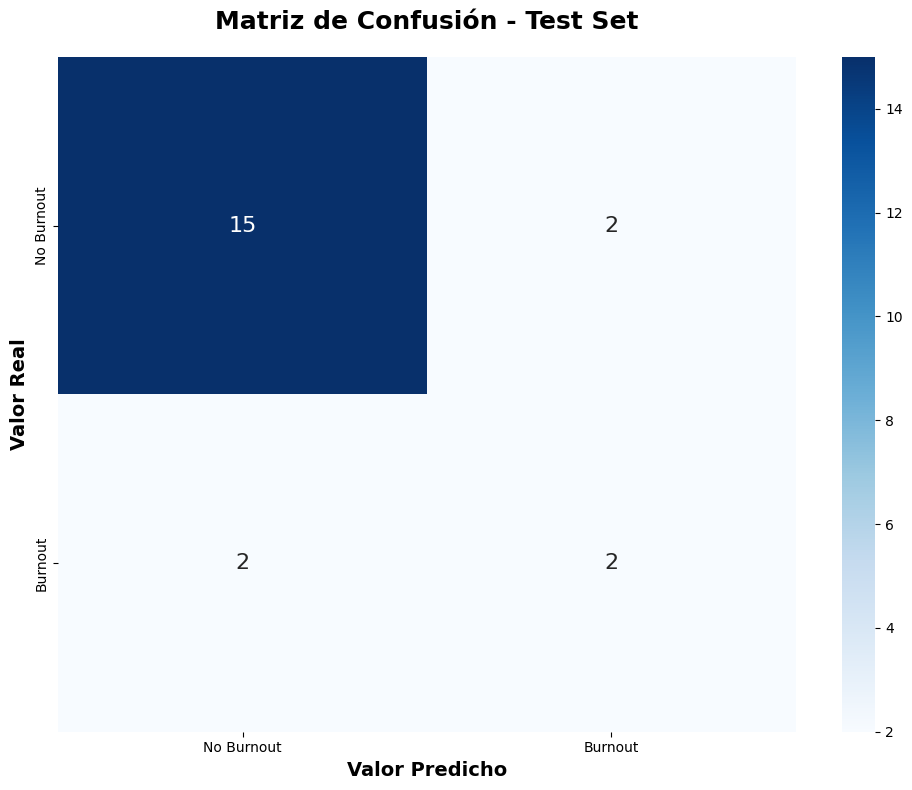

In [ ]:
# Escalar el test set usando el MISMO scaler ajustado en el train set
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Predecir en el test set
y_test_pred = best_clf_model.predict(X_test_scaled)
y_test_proba = best_clf_model.predict_proba(X_test_scaled)

print("\n================ RESULTADOS FINALES EN TEST SET (Clasificación) ================")
accuracy = accuracy_score(y_test, y_test_pred)

# Para AUC-ROC en clasificación binaria, usar solo las probabilidades de la clase positiva (columna 1)
auc_score = roc_auc_score(y_test, y_test_proba[:, 1])

f1_macro = f1_score(y_test, y_test_pred, average='macro')
precision_macro = precision_score(y_test, y_test_pred)
recall_macro = recall_score(y_test, y_test_pred)

print(f"\n✓ Accuracy: {accuracy:.4f}")
print(f"✓ Precision (macro): {precision_macro:.4f}")
print(f"✓ Recall (macro): {recall_macro:.4f}")
print(f"✓ F1-Score (macro): {f1_macro:.4f}")
print(f"✓ AUC-ROC: {auc_score:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=['No Burnout', 'Burnout']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Burnout', 'Burnout'], 
            yticklabels=['No Burnout', 'Burnout'],
            annot_kws={'size': 16})
plt.title('Matriz de Confusión - Test Set', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.xlabel('Valor Predicho', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 7. Búsqueda de Hiperparámetros y Entrenamiento (Regresión)

In [13]:
# Escalar datos de entrenamiento para regresión
scaler_reg = StandardScaler()
X_train_reg_scaled = X_train_reg.copy()
X_train_reg_scaled[cols_to_scale] = scaler_reg.fit_transform(X_train_reg[cols_to_scale])

print("Iniciando GridSearchCV para el modelo de regresión...")
xgb_reg = xgb.XGBRegressor(random_state=42)

grid_search_reg = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid, # Reutilizamos el mismo espacio de búsqueda
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_reg.fit(X_train_reg_scaled, y_train_reg)

print("\n================ MEJORES HIPERPARÁMETROS (Regresión) ================")
print(grid_search_reg.best_params_)
print(f"\nMejor MSE en CV: {-grid_search_reg.best_score_:.4f}")

# Modelo final de regresión
best_reg_model = grid_search_reg.best_estimator_

Iniciando GridSearchCV para el modelo de regresión...
Fitting 5 folds for each of 14580 candidates, totalling 72900 fits

================ MEJORES HIPERPARÁMETROS (Regresión) ================
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.8}

Mejor MSE en CV: 0.0885


### 8. Evaluación del Modelo de Regresión en el Test Set


================ RESULTADOS FINALES EN TEST SET (Regresión) ================

✓ R² Score: 0.0825 (El modelo explica el 8.25% de la varianza)
✓ MAE (Mean Absolute Error): 0.2859
✓ RMSE (Root Mean Square Error): 0.4080
✓ MSE (Mean Squared Error): 0.1664


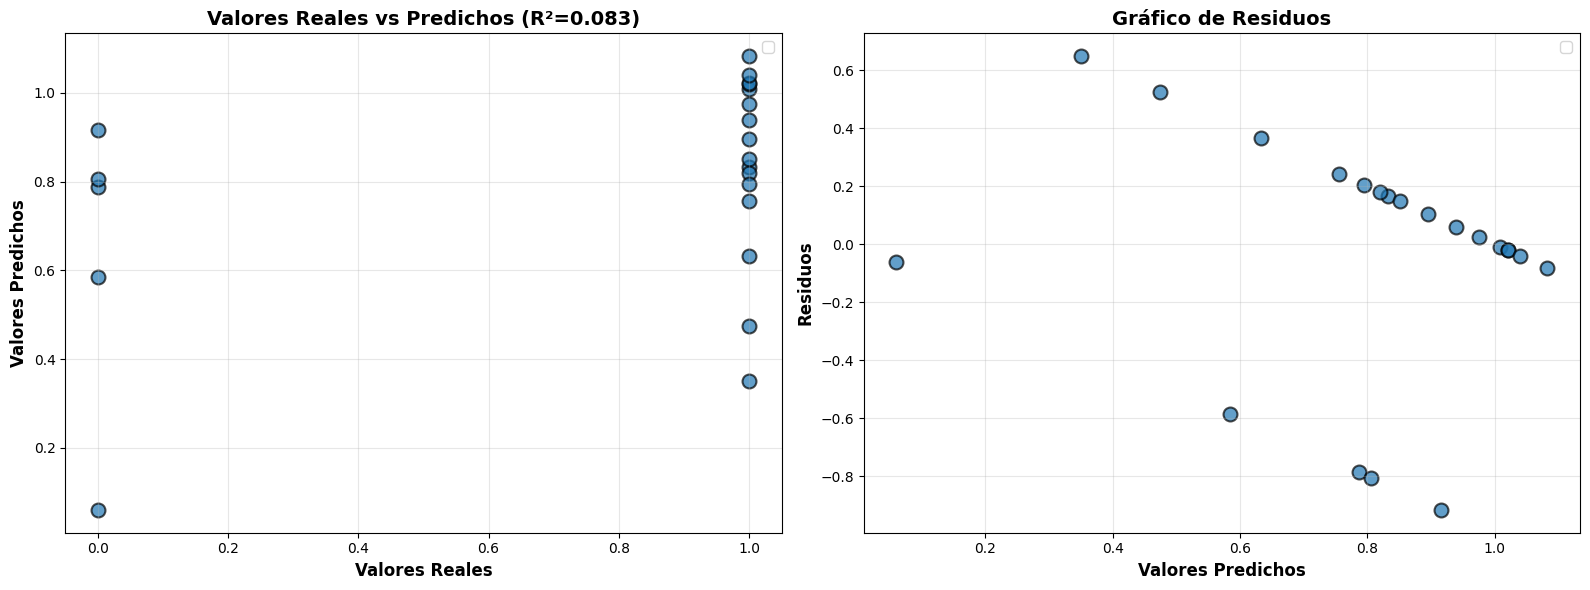

In [18]:
# Escalar test set de regresión
X_test_reg_scaled = X_test_reg.copy()
X_test_reg_scaled[cols_to_scale] = scaler_reg.transform(X_test_reg[cols_to_scale])

# Predicciones
y_test_reg_pred = best_reg_model.predict(X_test_reg_scaled)

# Convertir y_test_reg a valores numéricos si es categórico
y_test_reg_numeric = pd.to_numeric(y_test_reg, errors='coerce')

print("\n================ RESULTADOS FINALES EN TEST SET (Regresión) ================")
r2 = r2_score(y_test_reg_numeric, y_test_reg_pred)
mae = mean_absolute_error(y_test_reg_numeric, y_test_reg_pred)
rmse = np.sqrt(mean_squared_error(y_test_reg_numeric, y_test_reg_pred))
mse = mean_squared_error(y_test_reg_numeric, y_test_reg_pred)

print(f"\n✓ R² Score: {r2:.4f} (El modelo explica el {r2*100:.2f}% de la varianza)")
print(f"✓ MAE (Mean Absolute Error): {mae:.4f}")
print(f"✓ RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"✓ MSE (Mean Squared Error): {mse:.4f}")

# Visualización de Resultados de Regresión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Valores Reales vs Predichos
axes[0].scatter(y_test_reg_numeric, y_test_reg_pred, alpha=0.7, s=100, edgecolors='k', linewidth=1.5)
min_val = min(y_test_reg_numeric.min(), y_test_reg_pred.min())
max_val = max(y_test_reg_numeric.max(), y_test_reg_pred.max())
axes[0].set_xlabel('Valores Reales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valores Predichos', fontsize=12, fontweight='bold')
axes[0].set_title(f'Valores Reales vs Predichos (R²={r2:.3f})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Gráfico de Residuos
residuals = y_test_reg_numeric - y_test_reg_pred
axes[1].scatter(y_test_reg_pred, residuals, alpha=0.7, s=100, edgecolors='k', linewidth=1.5)
axes[1].set_xlabel('Valores Predichos', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuos', fontsize=12, fontweight='bold')
axes[1].set_title('Gráfico de Residuos', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9. Análisis de Importancia de Características (Feature Importance)

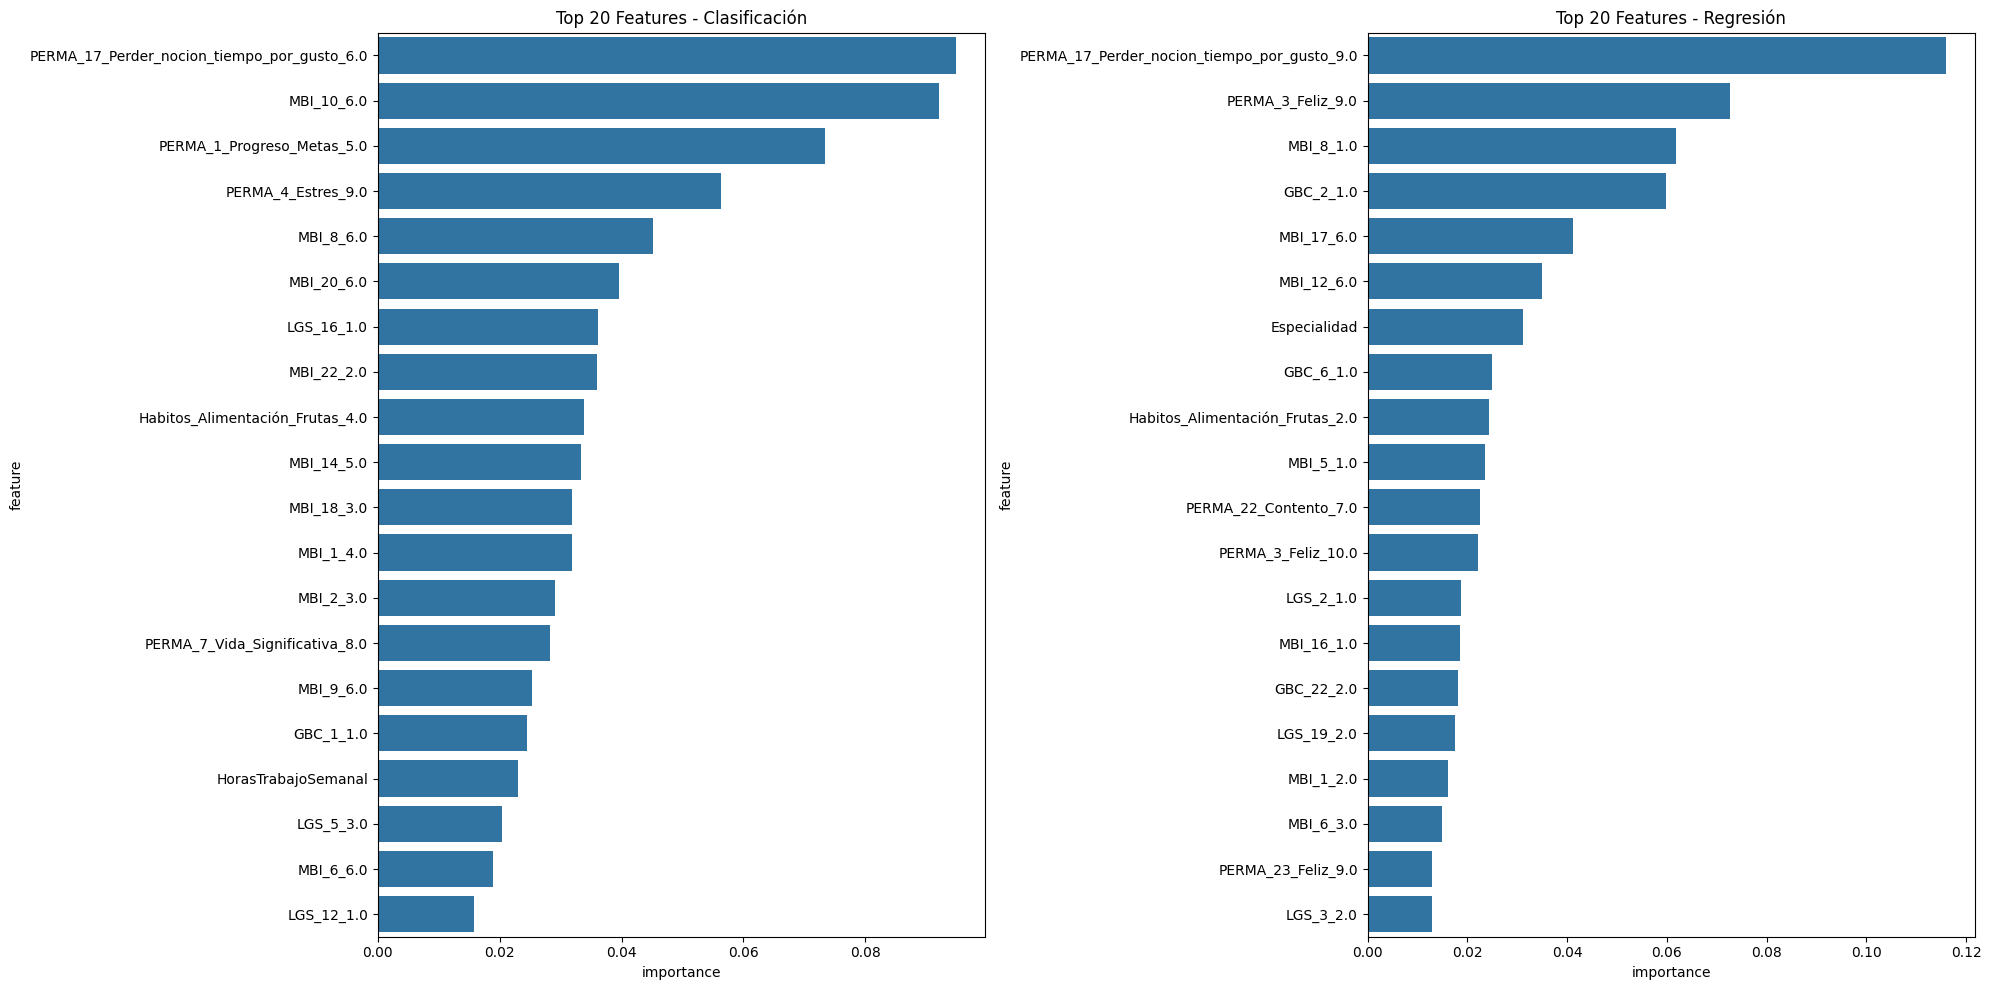

In [15]:
# Obtener importancia de características para ambos modelos
feature_importance_clf = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance': best_clf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_reg = pd.DataFrame({
    'feature': X_train_reg.columns,
    'importance': best_reg_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(x='importance', y='feature', data=feature_importance_clf.head(20), ax=axes[0])
axes[0].set_title('Top 20 Features - Clasificación')

sns.barplot(x='importance', y='feature', data=feature_importance_reg.head(20), ax=axes[1])
axes[1].set_title('Top 20 Features - Regresión')

plt.tight_layout()
plt.show()